In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

### Import edges2shoes Data and Process Into Train / Test

In [2]:
shoe_url = "https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/edges2shoes.tar.gz"

zip_path = tf.keras.utils.get_file('edges2shoes.tar.gz', origin=shoe_url, extract=True)
path = os.path.join(os.path.dirname(zip_path), 'edges2shoes/')

2165284864/2165283376 [==============================] - 98s 0us/step


In [3]:
# images in the zip are side by side: left side edges, right side full shoe
# loads image, splits into the two pieces, casts to float, resizes to 256x256, normalizes values to [0, 1]

def process_image(file):
    image = tf.image.decode_jpeg(tf.io.read_file(file)) # load

    width = tf.shape(image)[1]
    width = width // 2
    
    edge = image[:, :width, :] # left side = edges
    shoe = image[:, width:, :] # right side = shoe
    
    edge = tf.cast(edge, tf.float32)
    shoe = tf.cast(shoe, tf.float32)
    
    edge = tf.image.resize(edge, [256, 256])
    shoe = tf.image.resize(shoe, [256, 256])
    
    edge = (edge / 255.0)
    shoe = (shoe / 255.0)

    return edge, shoe

In [4]:
train_ds = tf.data.Dataset.list_files(path + "train/*.jpg")
test_ds = tf.data.Dataset.list_files(path + "val/*.jpg")

In [5]:
train_ds = train_ds.map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# from paper - ran with batch size 4 for 15 epochs
train_ds = train_ds.batch(4)
test_ds = test_ds.batch(4)

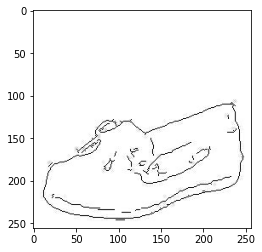

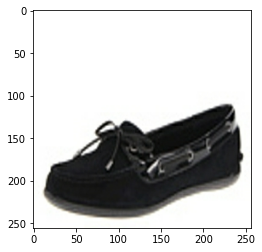

In [6]:
# example images
for shape in train_ds.take(1):
    plt.imshow(shape[0][0])
    plt.show()
    plt.imshow(shape[1][0])

### Build Generator Architecture

In [7]:
# Need encoder, decoder (with and without dropout) blocks
# "Weights were initialized from a Gaussian distribution with mean 0 and standard deviation 0.02"

def encode(inputs, filters, kernels):
    weight_init = tf.random_normal_initializer(0.0, 0.02)
    x = tf.keras.layers.Conv2D(filters, kernels, strides=2, padding='same', kernel_initializer=weight_init)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

def decode_with_dropout(inputs, filters, kernels):
    weight_init = tf.random_normal_initializer(0.0, 0.02)
    x = tf.keras.layers.Conv2DTranspose(filters, kernels, strides=2, padding='same', kernel_initializer=weight_init)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def decode_no_dropout(inputs, filters, kernels):
    weight_init = tf.random_normal_initializer(0.0, 0.02)
    x = tf.keras.layers.Conv2DTranspose(filters, kernels, strides=2, padding='same', kernel_initializer=weight_init)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

In [8]:
# encode: C64-C128-C256-C512-C512-C512-C512-C512 -> 64 layer does not have BatchNorm
# decode: CD512-CD512-CD512-C512-C256-C128-C64
# final stage: convolution to 3 output channels, tanh activation

def Generator():
    inputs = tf.keras.Input(shape=[256, 256, 3]) # all images resized to this shape
    weight_init = tf.random_normal_initializer(0.0, 0.02)
    skip_cons = [] # skip connections, to pair encoding with decoding (one for each encoding layer)
    
    # downsampling
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=weight_init)(inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # no BatchNorm
    skip_cons.append(x)
    
    x = encode(x, 128, 4)
    skip_cons.append(x)
    
    x = encode(x, 256, 4)
    skip_cons.append(x)
    
    for i in range(5):
        x = encode(x, 512, 4)
        skip_cons.append(x)
        
    # upsampling
    reverse_skips = skip_cons[:-1] # do not include last one - only 7 layers in upsampling (before last layer)
    reverse_skips.reverse() # will match the encoded in reverse order as upsampled
    
    for i in range(3):
        x = decode_with_dropout(x, 512, 4)
        x = tf.keras.layers.Concatenate()([x, reverse_skips[i]])
        
    x = decode_no_dropout(x, 512, 4)
    x = tf.keras.layers.Concatenate()([x, reverse_skips[3]])
    
    x = decode_no_dropout(x, 256, 4)
    x = tf.keras.layers.Concatenate()([x, reverse_skips[4]])
    
    x = decode_no_dropout(x, 128, 4)
    x = tf.keras.layers.Concatenate()([x, reverse_skips[5]])
    
    x = decode_no_dropout(x, 64, 4)
    x = tf.keras.layers.Concatenate()([x, reverse_skips[6]])
    
    # last layer
    x = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=weight_init, activation='tanh')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

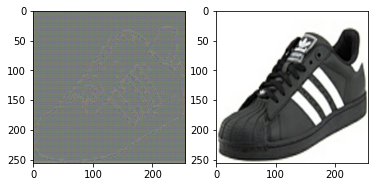

In [9]:
generator = Generator()
pic = next(iter(train_ds))
generated = generator(pic, training = False)
generated = (generated-np.min(generated))/(np.max(generated)-np.min(generated)) # normalized
plt.subplot(1, 2, 1)
plt.imshow(generated[0, ...])
plt.subplot(1, 2, 2)
plt.imshow(pic[1][0])
plt.show()

### Build Discriminator Architecture

In [10]:
# 70 x 70 PatchGAN: C64-C128-C256-C512 (no Batchnorm on first convolution)
# followed by a Conv map to 1d output and a sigmoid function

def Discriminator():
    weight_init = tf.random_normal_initializer(0.0, 0.02)
    
    fake_image = tf.keras.layers.Input(shape=[256, 256, 3])
    target_image = tf.keras.layers.Input(shape=[256, 256, 3])
    
    x = tf.keras.layers.concatenate([fake_image, target_image])
    
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=weight_init)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=weight_init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=weight_init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=weight_init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same', kernel_initializer=weight_init)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=weight_init, activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=[fake_image, target_image], outputs=x)

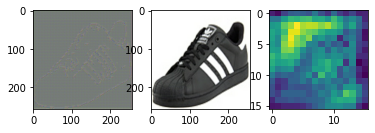

In [11]:
discriminator = Discriminator()
prediction = discriminator([generated[0, tf.newaxis, ...], pic[1][0][tf.newaxis, ...]], training=False)
plt.subplot(1, 3, 1)
plt.imshow(generated[0, ...])
plt.subplot(1, 3, 2)
plt.imshow(pic[1][0])
plt.subplot(1, 3, 3)
plt.imshow(prediction[0,...,-1])
plt.show()

### Full pix2pix Model

In [12]:
# optimizer (same for both, defined in paper)
gen_optimizer = tf.keras.optimizers.Adam(0.002, beta_1 = 0.5, beta_2=0.999)
disc_optimizer = tf.keras.optimizers.Adam(0.002, beta_1 = 0.5, beta_2=0.999)

In [13]:
# loss functions
# train to maximize log D(x, G(x, z))
LAMBDA = 100 # defined in paper

def generator_loss(disc_gen_output, gen_output, target):
    
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_gen_output), disc_gen_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    return gan_loss + (LAMBDA * l1_loss)

def discriminator_loss(disc_real_output, disc_gen_output):

    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_gen_output), disc_gen_output)

    return real_loss + gen_loss

In [18]:
# training step

@tf.function
def train_step(input_image, target_image, epoch):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target_image], training=True)
        disc_gen_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_gen_output, gen_output, target_image)
        disc_loss = discriminator_loss(disc_real_output, disc_gen_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [15]:
# functions to plot training examples and save models (to be performed every epoch)

def generate_images(gen_model, input_image, target):
    prediction = gen_model(input_image, training=True)
    prediction = (prediction-np.min(prediction))/(np.max(prediction)-np.min(prediction)) # normalized
    display_list = [input_image[0], target[0], prediction[0]]
  
    titles = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()
    
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=disc_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
# plot, train, and save model

def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target) # evaluate how some test data looks each epoch
        print("Epoch: ", epoch)

        # Train - print dots to track progress through training
        for n, (input_image, target) in train_ds.enumerate():
            if (n % 100) == 0:
              print('.', end='')
            gen_loss, disc_loss = train_step(input_image, target, epoch)
        print('Gen Loss: {}, Disc Loss: {}'.format(gen_loss, disc_loss))

        # checkpoint the model every epoch
        checkpoint.save(file_prefix = checkpoint_prefix)

### Train on edges2shoes Data

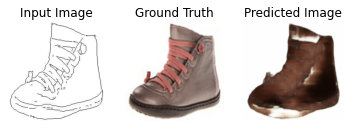

Epoch:  0
.............................................................................................................................Gen Loss: 3.287670373916626, Disc Loss: 1.3849459886550903


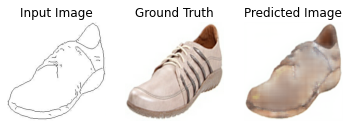

Epoch:  1
.............................................................................................................................Gen Loss: 2.9509010314941406, Disc Loss: 1.3862943649291992


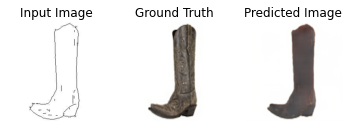

Epoch:  2
.............................................................................................................................Gen Loss: 8.055831909179688, Disc Loss: 1.258826494216919


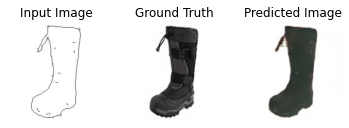

Epoch:  3
.............................................................................................................................Gen Loss: 8.090801239013672, Disc Loss: 1.0064854621887207


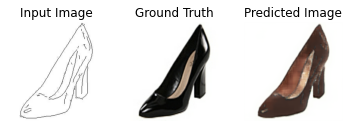

Epoch:  4
.............................................................................................................................Gen Loss: 4.425467491149902, Disc Loss: 1.006408929824829


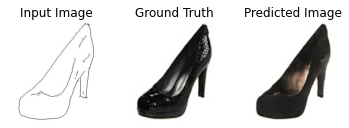

Epoch:  5
.............................................................................................................................Gen Loss: 5.436489582061768, Disc Loss: 1.006408929824829


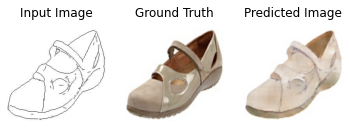

Epoch:  6
.............................................................................................................................Gen Loss: 4.437910079956055, Disc Loss: 1.3862943649291992


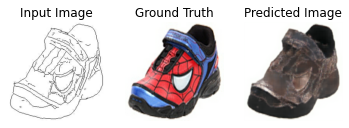

Epoch:  7
.............................................................................................................................Gen Loss: 2.3432557582855225, Disc Loss: 1.3862943649291992


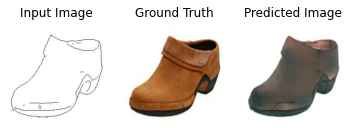

Epoch:  8
.............................................................................................................................Gen Loss: 4.181807041168213, Disc Loss: 1.006408929824829


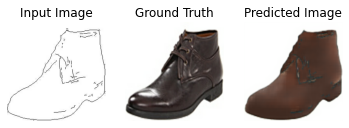

Epoch:  9
.............................................................................................................................Gen Loss: 9.149682998657227, Disc Loss: 1.006408929824829


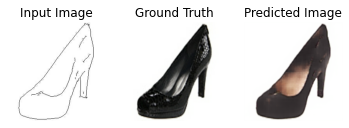

Epoch:  10
.............................................................................................................................Gen Loss: 6.407806396484375, Disc Loss: 1.6265236139297485


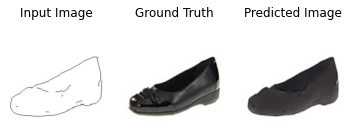

Epoch:  11
.............................................................................................................................Gen Loss: 5.757054805755615, Disc Loss: 1.6265236139297485


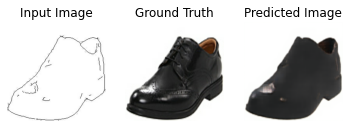

Epoch:  12
.............................................................................................................................Gen Loss: 5.536136150360107, Disc Loss: 1.006408929824829


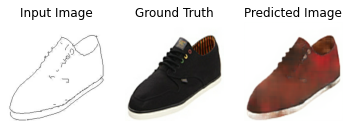

Epoch:  13
.............................................................................................................................Gen Loss: 5.65885591506958, Disc Loss: 1.006408929824829


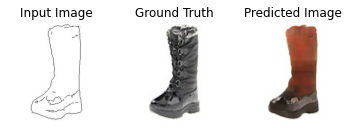

Epoch:  14
.............................................................................................................................Gen Loss: 3.5471837520599365, Disc Loss: 1.3862943649291992


In [20]:
fit(train_ds, 15, test_ds)

In [24]:
ls {checkpoint_dir}

checkpoint                   ckpt-2.index
ckpt-10.data-00000-of-00001  ckpt-3.data-00000-of-00001
ckpt-10.index                ckpt-3.index
ckpt-11.data-00000-of-00001  ckpt-4.data-00000-of-00001
ckpt-11.index                ckpt-4.index
ckpt-12.data-00000-of-00001  ckpt-5.data-00000-of-00001
ckpt-12.index                ckpt-5.index
ckpt-13.data-00000-of-00001  ckpt-6.data-00000-of-00001
ckpt-13.index                ckpt-6.index
ckpt-14.data-00000-of-00001  ckpt-7.data-00000-of-00001
ckpt-14.index                ckpt-7.index
ckpt-15.data-00000-of-00001  ckpt-8.data-00000-of-00001
ckpt-15.index                ckpt-8.index
ckpt-1.data-00000-of-00001   ckpt-9.data-00000-of-00001
ckpt-1.index                 ckpt-9.index
ckpt-2.data-00000-of-00001


In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

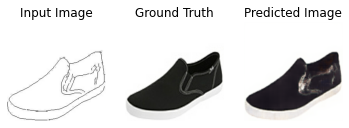

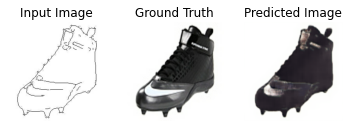

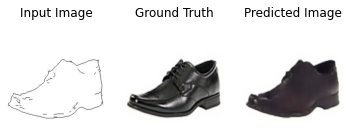

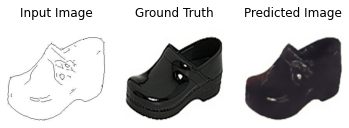

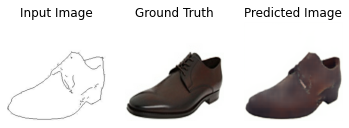

In [27]:
for input, target in test_ds.take(5):
  generate_images(generator, input, target)